# Download Package

In [1]:
!pip install simplet5 rouge_score 

  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 41.8 MB/s eta 0:00:00
  Created wheel for simplet5: filename=simplet5-0.1.4-py3-none-any.whl size=6854 sha256=baa57484f02de41fdd5932816fe4e7a131f07e98c89c5e7f81f3beb9d14d05aa
  Stored in directory: /root/.cache/pip/wheels/b4/7d/af/743765400878438a7593f13f89fdf4004dcde0f2a8e6cb6684
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=f2a0e965f63e34ca48077db35ffb33d7ad3cfc60cb64eb581d30671b0af53c99
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17

# Import Library

In [2]:
# For data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# For model, tokenizer
from simplet5 import SimpleT5
import transformers
from transformers import AutoTokenizer, AutoConfig, T5ForConditionalGeneration

# For evaluate
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# For visualization
import matplotlib.pyplot as plt

# For neccessary
import re
import os
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

# Load dataset

In [3]:
train_df = pd.read_csv("/kaggle/input/t5-skinchat-data-tokenizer-preparation/data_train.csv")
valid_df = pd.read_csv("/kaggle/input/t5-skinchat-data-tokenizer-preparation/data_valid.csv")
test_df = pd.read_csv("/kaggle/input/t5-skinchat-data-tokenizer-preparation/data_test.csv")

train_df.shape, valid_df.shape, test_df.shape

((220697, 2), (130, 2), (130, 2))

# Load Tokenizer

In [4]:
MODEL_NAME = "t5-base"
MAX_VOCAB = 20000

In [5]:
new_tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/t5-skinchat-training-4/outputs/simplet5-epoch-4-train-loss-0.7205-val-loss-0.7586/")

# Load Model

In [6]:
model = T5ForConditionalGeneration.from_pretrained("/kaggle/input/t5-skinchat-training-4/outputs/simplet5-epoch-4-train-loss-0.7205-val-loss-0.7586/")

In [7]:
# instantiate
simplet5 = SimpleT5()

simplet5.model = model
simplet5.load_model("/kaggle/input/t5-skinchat-training-4/outputs/simplet5-epoch-4-train-loss-0.7205-val-loss-0.7586/", use_gpu=True)
simplet5.tokenizer = new_tokenizer

In [8]:
total_params = sum(p.numel() for p in simplet5.model.parameters())
print(f"Tổng số tham số của mô hình: {total_params}")
simplet5.model

Tổng số tham số của mô hình: 213589248


T5ForConditionalGeneration(
  (shared): Embedding(20000, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(20000, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

# Training Progress Visualization

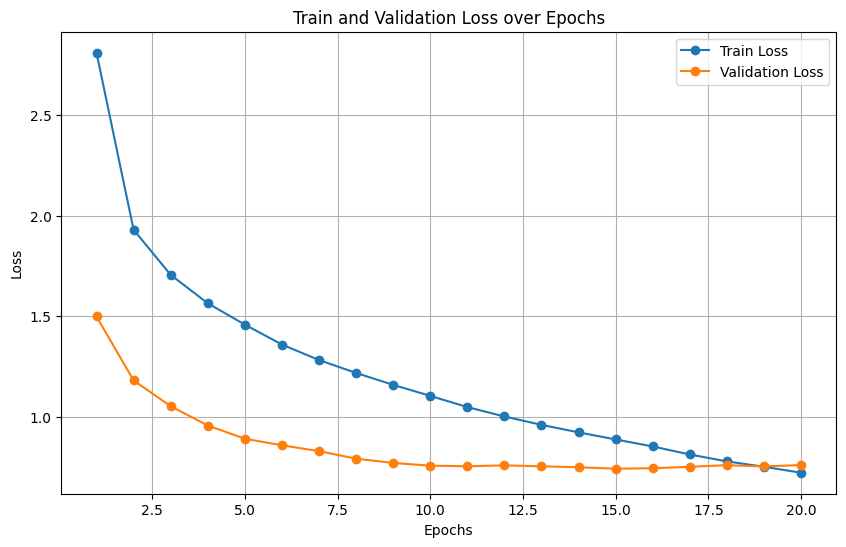

In [9]:
epochs = range(1, 21)
train_loss = [
    2.8112, 1.93, 1.7054, 1.564, 1.4577, 1.3586, 1.2814, 1.2171, 1.158, 1.1031, 
    1.0473, 1.0004, 0.9588, 0.9214, 0.8861, 0.8513, 0.8113, 0.7769, 0.7501, 0.7205
]
val_loss = [
    1.4982, 1.1801, 1.0517, 0.9555, 0.8898, 0.8571, 0.8279, 0.7905, 0.7691, 0.7557,
    0.7525, 0.757, 0.7523, 0.7479, 0.7404, 0.743, 0.75, 0.7581, 0.7519, 0.7586
]
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()

plt.grid(True)
plt.show()


# Evaluate

In [10]:
def calculate_f1_score(true_answer, predicted_answer):
    # Tiền xử lý: loại bỏ dấu câu và đưa về chữ thường
    true_tokens = re.findall(r'\w+', true_answer.lower())
    pred_tokens = re.findall(r'\w+', predicted_answer.lower())
    
    # Tìm các từ chung giữa hai câu
    common_tokens = set(true_tokens) & set(pred_tokens)
    
    if not common_tokens:
        return 0.0
    
    # Tính Precision và Recall
    precision = len(common_tokens) / len(pred_tokens)
    recall = len(common_tokens) / len(true_tokens)
    
    # Tính F1 Score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1

In [11]:
def calculate_bleu_score(true_answer, predicted_answer):
    # Tokenize câu trả lời mẫu và câu trả lời dự đoán
    true_tokens = [true_answer.lower().split()]
    pred_tokens = predicted_answer.lower().split()
    
    # Tính BLEU Score với smoothing để tránh trường hợp BLEU = 0 khi không có n-gram nào trùng khớp
    smoothie = SmoothingFunction().method4
    bleu = sentence_bleu(true_tokens, pred_tokens, smoothing_function=smoothie)
    return bleu

In [12]:
def calculate_rouge_scores(true_answer, predicted_answer):
    # Khởi tạo ROUGE Scorer với ROUGE-1, ROUGE-2, và ROUGE-L
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(true_answer, predicted_answer)
    
    # Trích xuất từng chỉ số ROUGE và trả về kết quả
    rouge_1 = scores['rouge1'].fmeasure
    rouge_2 = scores['rouge2'].fmeasure
    rouge_l = scores['rougeL'].fmeasure
    
    return rouge_1, rouge_2, rouge_l

In [13]:
# Khởi tạo các biến để lưu tổng các chỉ số
total_f1, total_bleu, total_rouge_1, total_rouge_2, total_rouge_l = 0, 0, 0, 0, 0
n = len(test_df)
skip = 0

for i in tqdm(range(n), desc="Evaluate"):
    try:
        # Lấy câu trả lời kỳ vọng và câu trả lời dự đoán
        expected_response = test_df['target_text'].iloc[i].replace('<newline>', '\n')
        actual_response = simplet5.predict(test_df['source_text'].iloc[i], skip_special_tokens=False)[0]
        actual_response = actual_response.replace('<pad> ', '').replace('</s>', '').replace('<newline>', '\n')

        # Tính các chỉ số
        f1 = calculate_f1_score(expected_response, actual_response)
        bleu = calculate_bleu_score(expected_response, actual_response)
        rouge_1, rouge_2, rouge_l = calculate_rouge_scores(expected_response, actual_response)
    except:
        skip +=1
        continue
    # Cộng dồn các chỉ số
    total_f1 += f1
    total_bleu += bleu
    total_rouge_1 += rouge_1
    total_rouge_2 += rouge_2
    total_rouge_l += rouge_l

# Tính trung bình các chỉ số
average_f1 = total_f1 / (n-skip)
average_bleu = total_bleu / (n-skip)
average_rouge_1 = total_rouge_1 / (n-skip)
average_rouge_2 = total_rouge_2 / (n-skip)
average_rouge_l = total_rouge_l / (n-skip)

# In ra kết quả trung bình
print("Evaluate:")
print(f"Average F1 Score: {average_f1:.4f}")
print(f"Average BLEU Score: {average_bleu:.4f}")
print(f"Average ROUGE-1 Score: {average_rouge_1:.4f}")
print(f"Average ROUGE-2 Score: {average_rouge_2:.4f}")
print(f"Average ROUGE-L Score: {average_rouge_l:.4f}")

Evaluate:   0%|          | 0/130 [00:00<?, ?it/s]

Evaluate:
Average F1 Score: 0.5830
Average BLEU Score: 0.3943
Average ROUGE-1 Score: 0.7540
Average ROUGE-2 Score: 0.5528
Average ROUGE-L Score: 0.6273
